In [4]:
import numpy as np
import scanpy as sc
import scprep
import matplotlib.pyplot as plt
import phate
import plotly3d.plot as p3
from sklearn.cluster import KMeans
import pandas as pd

In [5]:
import numpy as np
import scanpy as sc
import scprep
import matplotlib.pyplot as plt
import phate
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [6]:
adata_all = sc.read('../data/balanced_subsampled2.h5ad')
# adata = adata_all[subsampled_df.index]
adata = adata_all

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


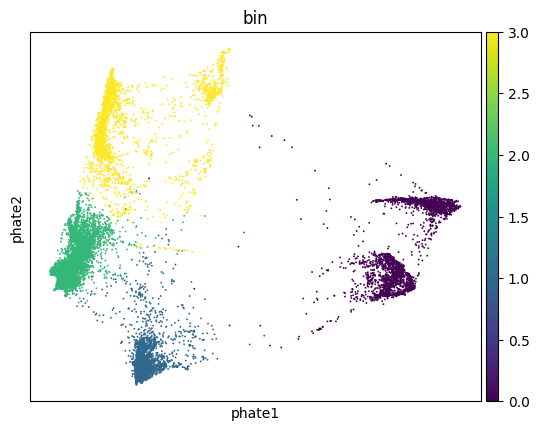

In [7]:
sc.external.pl.phate(adata, color='bin')


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


3    1444
0    1087
2     380
1     252
dtype: int64


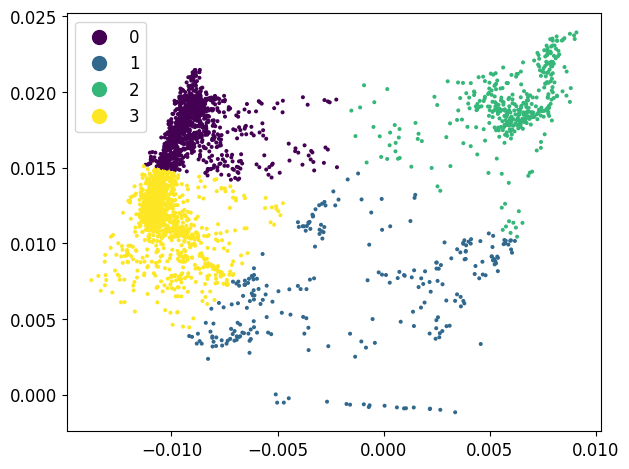

In [8]:
t = 3
bin_adata = adata[adata.obs['bin'] == t].copy()
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(bin_adata.obsm['X_phate'])
bin_adata.obs['cluster'] = kmeans.labels_
scprep.plot.scatter2d(bin_adata.obsm['X_phate'], bin_adata.obs['cluster'], cmap='viridis')
cluster_counts = pd.Series(kmeans.labels_).value_counts()
print(cluster_counts)
barcodes_4 = bin_adata.obs.index[pd.Series(kmeans.labels_).isin([0, 2])]

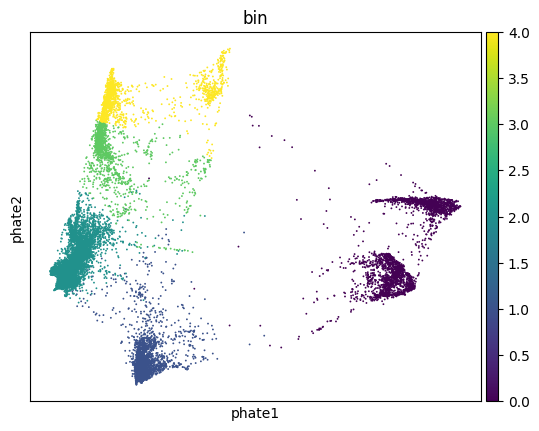

In [9]:
adata.obs.loc[barcodes_4, 'bin'] = 4
sc.external.pl.phate(adata, color='bin')

In [75]:
from ot.unbalanced import sinkhorn_knopp_unbalanced
from scipy.spatial.distance import cdist

def get_transform_matrix(gamma, a, epsilon=1e-8):
    return (np.diag(1.0 / (a+ epsilon)) @ gamma).T

def get_growth_coeffs(gamma, a, epsilon=1e-8, normalize=False):                                                                         
    T = get_transform_matrix(gamma, a, epsilon)                                                                                         
    unnormalized_coeffs = np.sum(T, axis=0)                                                                                             
    if not normalize:                                                                                                                   
        return unnormalized_coeffs                                                                                                      
    return unnormalized_coeffs / np.sum(unnormalized_coeffs) * len(unnormalized_coeffs)   

def calc_growth(source, target):
    # alpha = 2
    alpha = 10
    a = adata.obsm['X_pca'][adata.obs['bin'] == source]
    b = adata.obsm['X_pca'][adata.obs['bin'] == target]
    m, n = a.shape[0], b.shape[0]
    M = cdist(a,b)
    entropy_reg = 0.1
    # reg_1, reg_2 = alpha, 10000
    reg_1, reg_2 = alpha, 10_000
    gamma = sinkhorn_knopp_unbalanced(np.ones(m) / m, np.ones(n) / n, M, entropy_reg, reg_1, reg_2)
    return get_growth_coeffs(gamma, np.ones(m) / m)

In [76]:
samples = np.unique(adata.obs['bin'])
print(samples)
dfs = []
for i in range(len(samples)):
    if i == 0:
        continue
    gc = calc_growth(samples[i - 1], samples[i])
    index = adata.obs.index[adata.obs['bin'] == samples[i-1]]
    df = pd.DataFrame(gc, index=index)
    dfs.append(df)
df = pd.concat(dfs)
df.columns = ['growth1']
dff = pd.concat([adata.obs[adata.obs['bin'] != 4], df], axis=1)
dff = dff.drop('growth', axis=1)
dff = dff.rename(columns={'growth1': 'growth'})


[0. 1. 2. 3. 4.]


<Axes: >

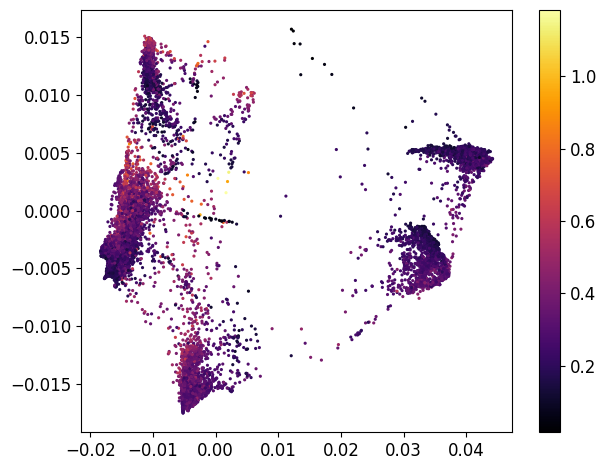

In [77]:
scprep.plot.scatter2d(adata[adata.obs['bin'] != 4].obsm['X_phate'].toarray(), dff['growth'].clip(upper=2), cmap='inferno')


<Axes: >

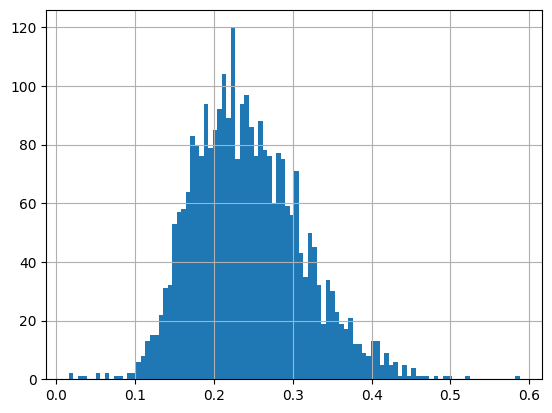

In [78]:
dff.loc[dff['bin'] == 0, 'growth'].hist(bins=100)


<Axes: >

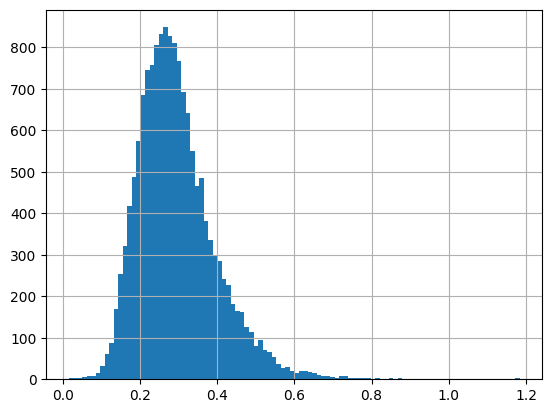

In [79]:
dff['growth'].hist(bins=100)

<Axes: >

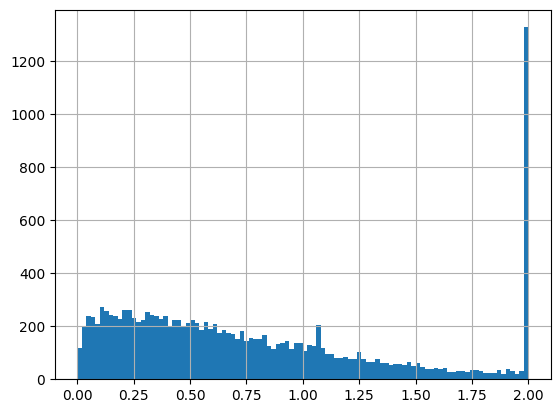

In [80]:
adata.obs['growth'].clip(upper=2).hist(bins=100)

<Axes: >

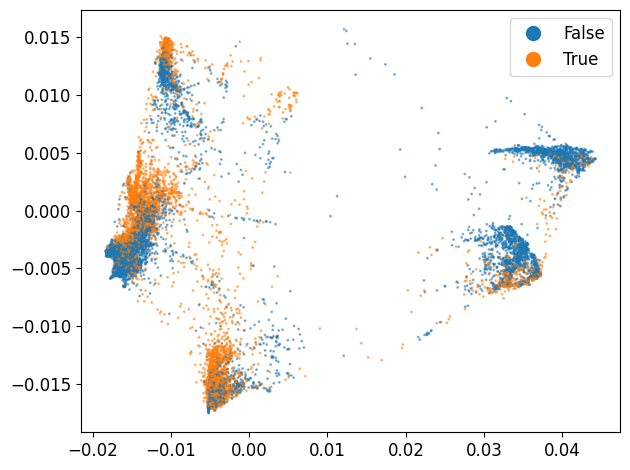

In [87]:
scprep.plot.scatter2d(adata[adata.obs['bin'] != 4].obsm['X_phate'].toarray(), dff['growth']>0.3, s=1, alpha=0.5)


<Axes: >

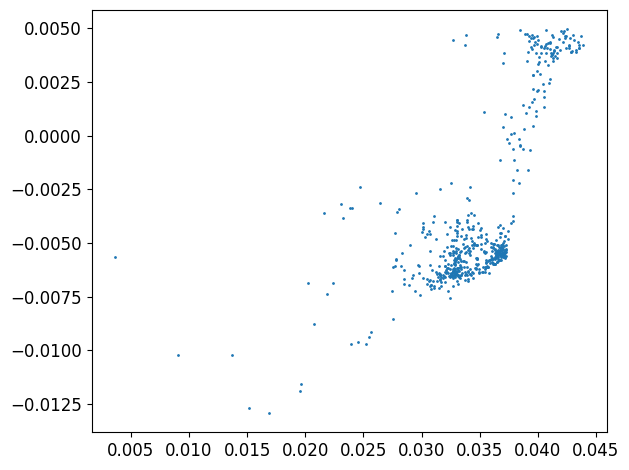

In [88]:
desired_index = list(set(dff.index[dff['growth']>0.3]).intersection(set(adata[adata.obs['bin'] == 0].obs_names)))
scprep.plot.scatter2d(adata[desired_index].obsm['X_phate'].toarray(), s=1)

In [89]:
dff['growth'].to_csv('../data/growth_rate3.csv')

In [90]:
mioflow_df = pd.DataFrame(adata.obsm['X_phate'], columns=['d1', 'd2'], index=adata.obs.index)
mioflow_df['samples'] = adata.obs['bin'].values
# Create a new empty DataFrame to store the subsampled data
subsampled_df = pd.DataFrame()

# Subsample each bin to exactly 500 points
n_samples_per_bin = min(1000, mioflow_df.groupby('samples').size().min())
for bin in range(len(mioflow_df['samples'].unique())):
    bin_df = mioflow_df[mioflow_df['samples'] == bin]
    if len(bin_df) >= n_samples_per_bin:
        sampled = bin_df.sample(n_samples_per_bin, random_state=42)
        subsampled_df = pd.concat([subsampled_df, sampled])
    else:
        subsampled_df = pd.concat([subsampled_df, bin_df])
# Save the balanced dataset
subsampled_df.to_csv('../data/mioflow_balanced_subsampled3.csv')

# Verify the counts
print(subsampled_df['samples'].value_counts())

0.0    1000
1.0    1000
2.0    1000
3.0    1000
4.0    1000
Name: samples, dtype: int64
